In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from Preprocess import preprocess_data, load_nifti, get_file_list, train_transforms, test_transforms, calculate_class_weights, count_class_frequencies, pad_image, FocalLoss
from torch.cuda.amp import GradScaler, autocast

In [2]:
# Class names based on provided labels
class_names = ['edema', 'non-enhancing tumor', 'enhancing tumour']

In [3]:
def pad_image(image, target_height, target_width):
    if len(image.shape) == 4:  # Case for 4D tensor
        _, _, h, w = image.shape
    elif len(image.shape) == 3:  # Case for 3D tensor
        _, h, w = image.shape
    else:
        raise ValueError(f"Unexpected image shape: {image.shape}")

    pad_h = target_height - h
    pad_w = target_width - w
    if len(image.shape) == 4:
        padded_image = F.pad(image, (0, pad_w, 0, pad_h), 'constant', 0)
    else:
        padded_image = F.pad(image, (0, pad_w, 0, pad_h), 'constant', 0)
    return padded_image

In [4]:
def dice_coefficient(predictions, ground_truth, num_classes):
    dice_scores = {}
    for cls in range(1, num_classes):  # Start from 1 to exclude background
        cls_pred = (predictions == cls).astype(np.uint8)
        cls_gt = (ground_truth == cls).astype(np.uint8)

        intersection = np.sum(cls_pred * cls_gt)
        denominator = np.sum(cls_pred) + np.sum(cls_gt)

        dice = (2. * intersection) / denominator if denominator != 0 else 1.0
        dice_scores[f'Class_{cls}'] = dice

    return dice_scores

In [5]:
def accuracy(predictions, ground_truth):
    correct = np.sum(predictions == ground_truth)
    total = np.prod(ground_truth.shape)
    return correct / total


In [6]:
def plot_dice_coefficients(dice_scores, epochs, class_names):
    plt.figure(figsize=(10, 5))
    data = [dice_scores[f'Class_{i}'] for i in range(1, len(class_names) + 1)]
    plt.boxplot(data, labels=class_names)
    plt.xlabel('Class')
    plt.ylabel('Dice Coefficient')
    plt.title('Boxplot of Dice Coefficient Per Class')
    plt.show()


In [7]:
# def calculate_sizes(segmentation_mask, num_classes):
#     sizes = []
#     for cls in range(1, num_classes):
#         sizes.append(np.sum(segmentation_mask == cls))
#     return sizes

In [8]:
# def bland_altman_plot(ground_truth_sizes, predicted_sizes, class_names):
#     for cls_idx, class_name in enumerate(class_names):
#         gt_sizes = [gt[cls_idx] for gt in ground_truth_sizes]
#         pred_sizes = [pred[cls_idx] for pred in predicted_sizes]

#         mean_sizes = [(gt + pred) / 2 for gt, pred in zip(gt_sizes, pred_sizes)]
#         diff_sizes = [gt - pred for gt, pred in zip(gt_sizes, pred_sizes)]

#         mean_diff = np.mean(diff_sizes)
#         std_diff = np.std(diff_sizes)

#         plt.figure(figsize=(10, 5))
#         plt.scatter(mean_sizes, diff_sizes, alpha=0.5)
#         plt.axhline(mean_diff, color='red', linestyle='--')
#         plt.axhline(mean_diff + 1.96 * std_diff, color='blue', linestyle='--')
#         plt.axhline(mean_diff - 1.96 * std_diff, color='blue', linestyle='--')
#         plt.xlabel('Mean Size')
#         plt.ylabel('Difference in Size')
#         plt.title(f'Bland-Altman Plot for {class_name}')
#         plt.show()

In [9]:
def train_epoch(model, optimizer, criterion, image_files, label_files, image_dir, label_dir, target_height, target_width, out_channels, device, transforms, scaler):
    epoch_loss = 0
    epoch_dice_scores = {f'Class_{cls}': [] for cls in range(1, out_channels)}
    correct_pixels = 0
    total_pixels = 0

    for img_file, lbl_file in zip(image_files, label_files):
        data = preprocess_data([img_file], [lbl_file], transforms, image_dir, label_dir)
        input_tensor = torch.tensor(data[0][0]).to(device).float()
        labels = torch.tensor(data[0][1], dtype=torch.long).to(device)

        slice_index = input_tensor.shape[-1] // 2
        input_slice = input_tensor[:, :, :, slice_index]  # Shape: [1, 1, H, W]
        input_slice = pad_image(input_slice, target_height, target_width)

        labels = labels[:, :, :, slice_index]  # Shape: [1, 1, H, W]
        labels = pad_image(labels, target_height, target_width)  # Shape: [1, 1, H, W]

        input_slice = input_slice.unsqueeze(0)
        labels = labels.unsqueeze(0)

        model.train()
        optimizer.zero_grad()

        with autocast():
            outputs = model(input_slice)
            loss = criterion(outputs, labels.squeeze(1))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        predicted_labels = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
        ground_truth = labels.squeeze(0).cpu().numpy()
        dice_scores = dice_coefficient(predicted_labels, ground_truth, out_channels)
        acc = accuracy(predicted_labels, ground_truth)

        correct_pixels += acc * ground_truth.size
        total_pixels += ground_truth.size

        for cls in range(1, out_channels):
            epoch_dice_scores[f'Class_{cls}'].append(dice_scores[f'Class_{cls}'])

    avg_epoch_loss = epoch_loss / len(image_files)
    avg_dice_scores = {cls: np.mean(scores) for cls, scores in epoch_dice_scores.items()}
    epoch_accuracy = correct_pixels / total_pixels

    return avg_epoch_loss, avg_dice_scores, epoch_accuracy

In [10]:
def val_model(model, criterion, image_files, label_files, image_dir, label_dir, target_height, target_width, out_channels, device, transforms):
    model.eval()
    epoch_loss = 0
    epoch_dice_scores = {f'Class_{cls}': [] for cls in range(1, out_channels)}
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for img_file, lbl_file in zip(image_files, label_files):
            data = preprocess_data([img_file], [lbl_file], transforms, image_dir, label_dir)
            input_tensor = torch.tensor(data[0][0]).to(device).float()
            labels = torch.tensor(data[0][1], dtype=torch.long).to(device)

            slice_index = input_tensor.shape[-1] // 2
            input_slice = input_tensor[:, :, :, slice_index]  # Shape: [1, 1, H, W]
            input_slice = pad_image(input_slice, target_height, target_width)

            labels = labels[:, :, :, slice_index]  # Shape: [1, 1, H, W]
            labels = pad_image(labels, target_height, target_width)  # Shape: [1, 1, H, W]

            input_slice = input_slice.unsqueeze(0)
            labels = labels.unsqueeze(0)

            outputs = model(input_slice)
            loss = criterion(outputs, labels.squeeze(1))
            epoch_loss += loss.item()

            predicted_labels = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
            ground_truth = labels.squeeze(0).cpu().numpy()
            dice_scores = dice_coefficient(predicted_labels, ground_truth, out_channels)
            acc = accuracy(predicted_labels, ground_truth)

            correct_pixels += acc * ground_truth.size
            total_pixels += ground_truth.size

            for cls in range(1, out_channels):
                epoch_dice_scores[f'Class_{cls}'].append(dice_scores[f'Class_{cls}'])

    avg_epoch_loss = epoch_loss / len(image_files)
    avg_dice_scores = {cls: np.mean(scores) for cls, scores in epoch_dice_scores.items()}
    epoch_accuracy = correct_pixels / total_pixels

    return avg_epoch_loss, avg_dice_scores, epoch_accuracy

In [11]:
def train_model(model, optimizer, criterion, train_image_files, train_label_files, val_image_files, val_label_files, image_dir, label_dir, val_dir, val_label_dir, epochs, target_height, target_width, out_channels, device, train_transforms, val_transforms, scheduler, early_stopping_patience):
    training_losses = []
    val_losses = []
    training_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    early_stopping_counter = 0
    scaler = GradScaler()

    final_train_dice_scores = None
    final_val_dice_scores = None

    for epoch in range(epochs):
        avg_train_loss, avg_train_dice_scores, train_acc = train_epoch(
            model, optimizer, criterion, train_image_files, train_label_files, image_dir, label_dir, target_height, target_width, out_channels, device, train_transforms, scaler
        )
        avg_val_loss, avg_val_dice_scores, val_acc = val_model(
            model, criterion, val_image_files, val_label_files, val_dir, val_label_dir, target_height, target_width, out_channels, device, val_transforms
        )

        training_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        training_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Training loss: {avg_train_loss}, Validation loss: {avg_val_loss}, Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}")
        print("Training Dice Scores: ", avg_train_dice_scores)
        print("Validation Dice Scores: ", avg_val_dice_scores)

        # Store the final Dice scores
        final_train_dice_scores = avg_train_dice_scores
        final_val_dice_scores = avg_val_dice_scores

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Print the final Dice scores after training is completed
    print("\nFinal Dice Scores after training:")
    print("Final Training Dice Scores: ", final_train_dice_scores)
    print("Final Validation Dice Scores: ", final_val_dice_scores)

    return training_losses, val_losses, training_accuracies, val_accuracies


In [12]:
# Main Execution Script
data_dir = 'C:/Users/td362/Downloads/Task01_BrainTumour/Task01_BrainTumour/imagesTr'
label_dir = 'C:/Users/td362/Downloads/Task01_BrainTumour/Task01_BrainTumour/labelsTr'
val_dir = 'C:/Users/td362/Downloads/Task01_BrainTumour/Task01_BrainTumour/imagesVal'
val_label_dir = 'C:/Users/td362/Downloads/Task01_BrainTumour/Task01_BrainTumour/labelsVal'

In [13]:
train_image_files = get_file_list(data_dir)
train_label_files = get_file_list(label_dir)

val_image_files = get_file_list(val_dir)
val_label_files = get_file_list(val_label_dir)

In [14]:
# train_image_files = get_file_list(data_dir)
# train_label_files = get_file_list(label_dir)

# val_image_files = get_file_list(val_dir)
# val_label_files = get_file_list(val_label_dir)

In [15]:
in_channels = 1
out_channels = 4

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
model = UNet(
    spatial_dims=2,  # For 2D images. Use spatial_dims=3 for 3D images
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(32, 64, 128, 256),  # Number of filters at each level (similar to SegResNet's filters)
    strides=(2, 2, 2),  # Strides for downsampling layers
    num_res_units=2,  # Adding depth with residual units to match the complexity
    norm=Norm.BATCH  # Use Batch Normalization, consistent with SegResNet

).to(device)



In [18]:
epochs = 100
target_height, target_width = 240, 240

In [19]:
criterion = FocalLoss(alpha=1, gamma=2, logits=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

C:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# Early stopping patience
early_stopping_patience = 10

In [21]:
# Train the model
training_losses, val_losses, training_accuracies, val_accuracies = train_model(
    model, optimizer, criterion, train_image_files, train_label_files, val_image_files, val_label_files,
    data_dir, label_dir, val_dir, val_label_dir, epochs, target_height, target_width, out_channels, device,
    train_transforms, test_transforms, scheduler, early_stopping_patience
)


C:\Users\td362\AppData\Local\Temp\ipykernel_29064\1041163.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\ProgramData\anaconda3\Lib\site-packages\monai\transforms\spatial\array.py:623: UserWarning: `data_array` is not of type `MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type `MetaTensor, assuming affine to be identity.")
C:\Users\td362\AppData\Local\Temp\ipykernel_29064\973629470.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100, Training loss: 0.3550988155603409, Validation loss: 0.1586115699971006, Training Accuracy: 0.8539989149305556, Validation Accuracy: 0.9723956266534391
Training Dice Scores:  {'Class_1': 0.2680827006224635, 'Class_2': 0.016097762311429755, 'Class_3': 0.07394448491220493}
Validation Dice Scores:  {'Class_1': 0.35852388646807476, 'Class_2': 0.02275019383369518, 'Class_3': 0.23510793073025651}
Epoch 2/100, Training loss: 0.09129035450518132, Validation loss: 0.05668631683857668, Training Accuracy: 0.9774464409722222, Validation Accuracy: 0.975480324074074
Training Dice Scores:  {'Class_1': 0.41270017461653796, 'Class_2': 0.05972632066940028, 'Class_3': 0.17415142026141978}
Validation Dice Scores:  {'Class_1': 0.41158060563897547, 'Class_2': 0.20565209904232365, 'Class_3': 0.23563067150603464}
Epoch 3/100, Training loss: 0.04348435525782406, Validation loss: 0.040023408486463484, Training Accuracy: 0.9796299045138889, Validation Accuracy: 0.9766288442460317
Training Dice Scores

In [22]:
def plot_losses_and_accuracy(training_losses, val_losses, training_accuracies, val_accuracies, epochs):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), training_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()

    plt.show()


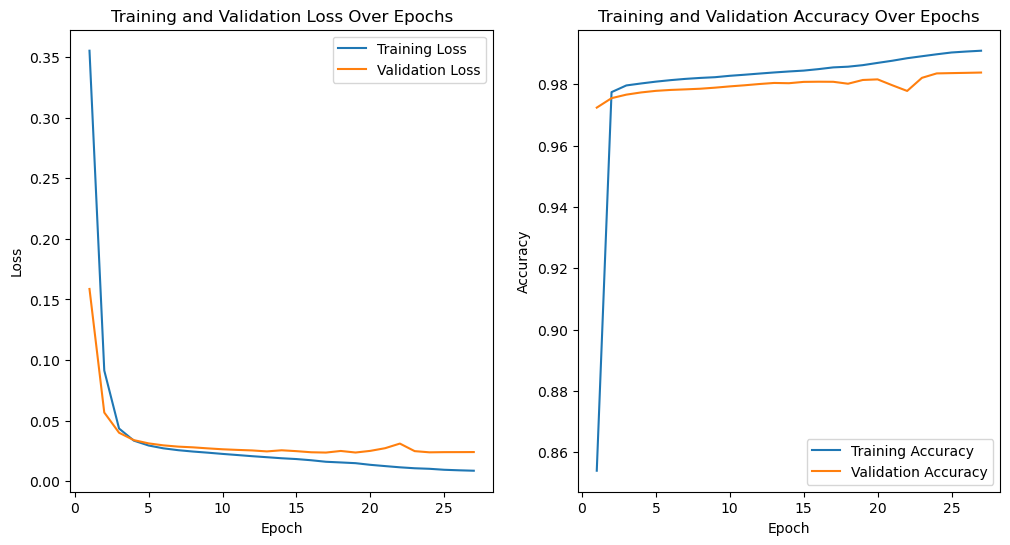

In [23]:
# After training the model, plot the training and validation loss and accuracy
plot_losses_and_accuracy(training_losses, val_losses, training_accuracies, val_accuracies, len(training_losses))


In [24]:
def apply_color_map(label):
    """
    Convert a label map (with integer class values) to an RGB image.
    """
    color_map = {
        0: [0, 0, 0],        # Background - Black
        1: [255, 0, 0],      # Edema - Red
        2: [0, 255, 0],      # Non-enhancing tumor - Green
        3: [0, 0, 255]       # Enhancing tumor - Blue
    }

    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for cls, color in color_map.items():
        rgb_image[label == cls] = color
    return rgb_image


In [25]:
def visualize_results(original_image, ground_truth, predicted_label, class_names):
    """
    Visualize the original image, ground truth, and predicted label side by side.
    """
    original_image = original_image.squeeze()  # Remove batch and channel dimensions if present
    ground_truth = ground_truth.squeeze()
    predicted_label = predicted_label.squeeze()

    ground_truth_rgb = apply_color_map(ground_truth)
    predicted_label_rgb = apply_color_map(predicted_label)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')

    axes[1].imshow(ground_truth_rgb)
    axes[1].set_title('Ground Truth')

    axes[2].imshow(predicted_label_rgb)
    axes[2].set_title('Predicted Label')

    plt.show()


In [26]:
def predict_image(model, image_file, label_file, image_dir, label_dir, target_height, target_width, out_channels, device, transforms):
    model.eval()
    with torch.no_grad():
        data = preprocess_data([image_file], [label_file], transforms, image_dir, label_dir)
        input_tensor = torch.tensor(data[0][0]).to(device).float()
        labels = torch.tensor(data[0][1], dtype=torch.long).to(device)

        # Select the middle slice of the 3D image
        slice_index = input_tensor.shape[-1] // 2
        input_slice = input_tensor[:, :, :, slice_index]  # Shape: [1, 1, H, W]
        input_slice = pad_image(input_slice, target_height, target_width)

        labels = labels[:, :, :, slice_index]  # Shape: [1, 1, H, W]
        labels = pad_image(labels, target_height, target_width)  # Shape: [1, 1, H, W]

        # Add a batch dimension
        input_slice = input_slice.unsqueeze(0)
        labels = labels.unsqueeze(0)

        outputs = model(input_slice)
        predicted_labels = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

        return input_slice.cpu().numpy(), labels.cpu().numpy(), predicted_labels


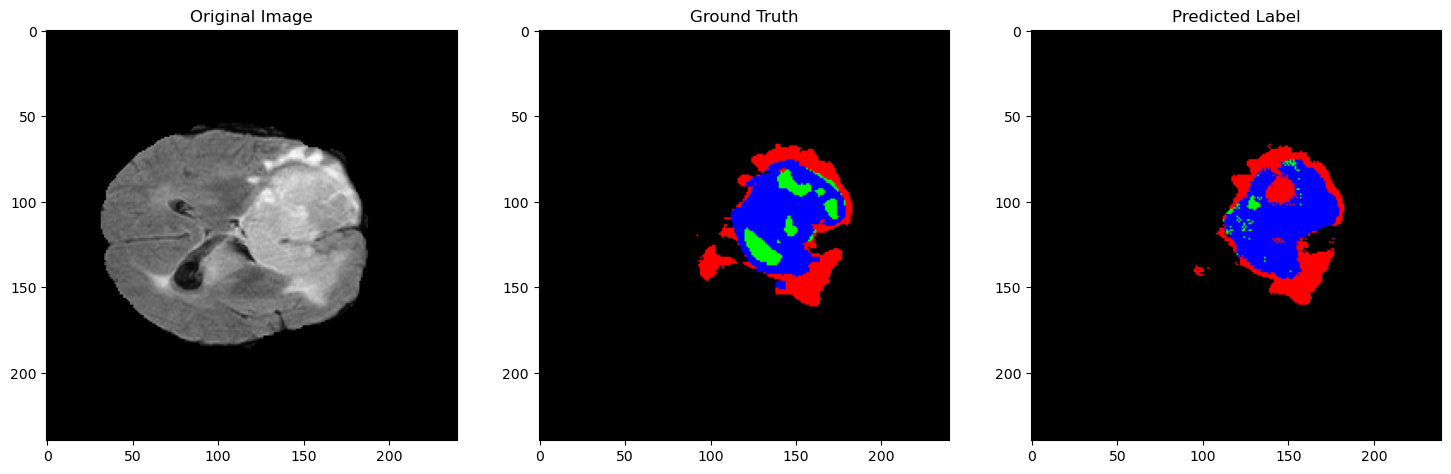

In [27]:
# Use the validation dataset for prediction and visualization
image_file = val_image_files[10]  # Select a validation image
label_file = val_label_files[10]  # Select the corresponding validation label

# Predict the image using the model
original_image, ground_truth, predicted_label = predict_image(
    model,
    image_file,
    label_file,
    val_dir,
    val_label_dir,
    target_height,
    target_width,
    out_channels,
    device,
    test_transforms  # Assuming you want to use the same transforms for validation as for testing
)

# Visualize the original image, ground truth, and predicted image
visualize_results(original_image, ground_truth, predicted_label, class_names)


In [28]:
# def compute_and_plot_bland_altman(model, image_files, label_files, image_dir, label_dir, target_height, target_width, out_channels, device, transforms, class_names):
#     ground_truth_sizes = []
#     predicted_sizes = []

#     model.eval()
#     with torch.no_grad():
#         for img_file, lbl_file in zip(image_files, label_files):
#             data = preprocess_data([img_file], [lbl_file], transforms, image_dir, label_dir)
#             input_tensor = torch.tensor(data[0][0]).to(device).float()
#             labels = torch.tensor(data[0][1], dtype=torch.long).to(device)

#             slice_index = input_tensor.shape[-1] // 2
#             input_slice = input_tensor[:, :, :, slice_index]
#             input_slice = pad_image(input_slice, target_height, target_width)

#             labels = labels[:, :, :, slice_index]
#             labels = pad_image(labels, target_height, target_width)

#             input_slice = input_slice.unsqueeze(0)
#             labels = labels.unsqueeze(0)

#             outputs = model(input_slice)
#             predicted_labels = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

#             gt_sizes = calculate_sizes(labels.squeeze().cpu().numpy(), out_channels)
#             pred_sizes = calculate_sizes(predicted_labels, out_channels)

#             ground_truth_sizes.append(gt_sizes)
#             predicted_sizes.append(pred_sizes)

#     bland_altman_plot(ground_truth_sizes, predicted_sizes, class_names)


In [29]:
# # Call the Bland-Altman plot function on the validation set
# compute_and_plot_bland_altman(
#     model,
#     val_image_files,
#     val_label_files,
#     val_dir,
#     val_label_dir,
#     target_height,
#     target_width,
#     out_channels,
#     device,
#     test_transforms,  # Use the same transforms as during validation
#     class_names
# )


In [31]:
test_dir = 'C:/Users/td362/Downloads/Task01_BrainTumour/Task01_BrainTumour/imagesTs'
test_label_dir = 'C:/Users/td362/Downloads/Task01_BrainTumour/Task01_BrainTumour/labelsTs'

# Load all test images and labels
test_image_files = get_file_list(test_dir)
test_label_files = get_file_list(test_label_dir)

In [32]:
model_save_path = "best_model_unet.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to best_model_unet.pth


In [33]:
# Load the state dictionary into the model
model.load_state_dict(torch.load("best_model_unet.pth"))
model.eval()  # Set the model to evaluation mode

C:\Users\td362\AppData\Local\Temp\ipykernel_29064\242485732.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_unet.pth"))


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convol

In [34]:
# Function to evaluate the model on the test dataset
def evaluate_model_on_test(model, test_image_files, test_label_files, test_dir, test_label_dir, target_height, target_width, out_channels, device, transforms):
    model.eval()
    total_dice_scores = {f'Class_{cls}': [] for cls in range(1, out_channels)}
    total_accuracy = []

    with torch.no_grad():
        for img_file, lbl_file in zip(test_image_files, test_label_files):
            original_image, ground_truth, predicted_label = predict_image(
                model,
                img_file,
                lbl_file,
                test_dir,
                test_label_dir,
                target_height,
                target_width,
                out_channels,
                device,
                transforms
            )

            # Compute Dice scores and accuracy
            dice_scores = dice_coefficient(predicted_label, ground_truth.squeeze(), out_channels)
            acc = accuracy(predicted_label, ground_truth.squeeze())

            for cls in range(1, out_channels):
                total_dice_scores[f'Class_{cls}'].append(dice_scores[f'Class_{cls}'])

            total_accuracy.append(acc)

    avg_dice_scores = {cls: np.mean(scores) for cls, scores in total_dice_scores.items()}
    avg_accuracy = np.mean(total_accuracy)

    print("Average Dice Scores on Test Set: ", avg_dice_scores)
    print("Average Accuracy on Test Set: ", avg_accuracy)

# Evaluate the model
evaluate_model_on_test(
    model,
    test_image_files,
    test_label_files,
    test_dir,
    test_label_dir,
    target_height,
    target_width,
    out_channels,
    device,
    test_transforms  # Using validation transforms
)


Average Dice Scores on Test Set:  {'Class_1': 0.5976479154397686, 'Class_2': 0.430364502407906, 'Class_3': 0.4978454085846169}
Average Accuracy on Test Set:  0.9833573325163399


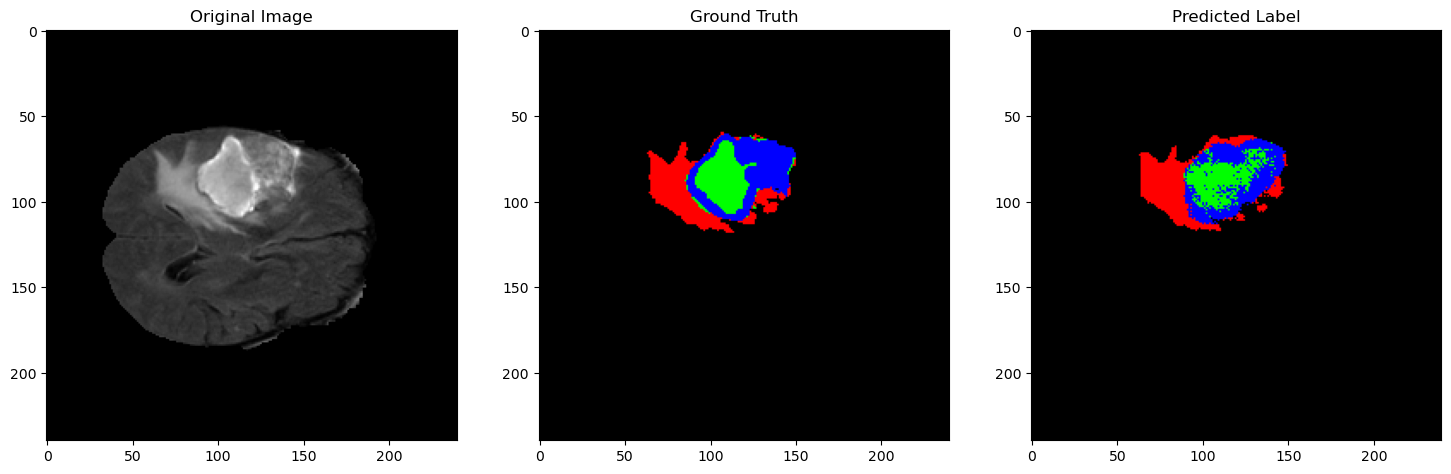

In [36]:
# Use the validation dataset for prediction and visualization
image_file = test_image_files[10]  # Select a validation image
label_file = test_label_files[10]  # Select the corresponding validation label

# Predict the image using the model
original_image, ground_truth, predicted_label = predict_image(
    model,
    image_file,
    label_file,
    val_dir,
    test_label_dir,
    target_height,
    target_width,
    out_channels,
    device,
    test_transforms  # Assuming you want to use the same transforms for validation as for testing
)

# Visualize the original image, ground truth, and predicted image
visualize_results(original_image, ground_truth, predicted_label, class_names)
